Extract a list of targeted sources

In [1]:
import requests # Downloading webpages
import bs4
from bs4 import BeautifulSoup # Extracting data from html files
import urllib.parse
from urllib.parse import urljoin
import time
from time import sleep # Time management
import tqdm # Processbar
import pathlib
from pathlib import Path # Working with files
import random # Generating pseudo random numbers
import pkg_resources # For citing modules
import selenium
from selenium import webdriver #selenium tools to automate web browsing
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import tensorflow

In [2]:
GFO_url = 'https://www.auswaertiges-amt.de/en/search?search=Russia%20and%20Ukraine'

# Use requests to fetch the initial HTML
GFO_req = requests.get(GFO_url)
GFO_soup = GFO_req.text
#Define needed variables for later use
all_GFO_urls = []
wait_time = random.uniform(2, 5)

#Opens the German Foreign Office Website
driver = webdriver.Chrome()
driver.get(GFO_url)

#Sets the filters specified in paper
time.sleep(wait_time) #pause to ensure website has loaded, and to make sure website doesn't identify us as a bot
open_filters = driver.find_element(by = By.CLASS_NAME, value = "c-cta--anchor-nav.is-search-toggler") 
open_filters.click()
time.sleep(wait_time)
filter1 = driver.find_element(by = By.CLASS_NAME, value = "filter__icon.i-speech")
filter1.click()
time.sleep(wait_time)
filter2 = driver.find_element(by = By.CLASS_NAME, value = "filter__icon.i-interview")
filter2.click()
time.sleep(wait_time)
start_date = driver.find_element(by = By.ID, value = "searchFromDate")
start_date.send_keys('2/17/22')
time.sleep(wait_time)
complete_filter = driver.find_element(by = By.ID, value = "submitDateFilter")
complete_filter.click()

# Use Selenium to load the page and fetch the complete HTML
for page in range(13):
    complete_GFO_content = driver.page_source
    parsed_GFO_content = BeautifulSoup(complete_GFO_content, 'html.parser')
    GFO_urls_ugly = parsed_GFO_content.find_all(class_='search-results__item-title') # extracting the links we want. By looking at the page with the inspect feature, we see that all the links we're interested in are classified with AccordionGrid_link__cGkec.
    GFO_urls = list(map(lambda x: urljoin(GFO_url, x['href']), GFO_urls_ugly)) # cleaning to get at list of constituency links
    all_GFO_urls.append(GFO_urls)
    time.sleep(wait_time)
    next_page = driver.find_element(by = By.CLASS_NAME, value = "pagination__button.is-next")
    next_page.click() 

all_GFO_urls = all_GFO_urls[1:]
#Close the browser window
driver.quit()

Convert targeted sources into .txt files

In [13]:
i = 1 #needed to number files 
#Retreives text data from all urls
for row in all_GFO_urls:
    for cell in row:
        driver = webdriver.Chrome()
        driver.get(cell)
        complete_url = driver.page_source
        parsed_complete_url = BeautifulSoup(complete_url, 'html.parser')
        url_date = driver.find_element(by = By.CLASS_NAME, value = 'heading__meta') #retreives date and type of media
        url_title = driver.find_element(by = By.CLASS_NAME, value = 'heading__title') #retreives title of source
        url_text_we = driver.find_element(by = By.CLASS_NAME, value = 'u-grid-col.is-desktop-col-9') #retrieves main text from urls
        url_text = url_date.text + ' ' + url_title.text + ''' 
''' + url_text_we.text #concatinates info into a single .txt file
        #Creates new .txt file in designated file location
        file_path = r'C:\Users\marc1\OneDrive\Desktop\Coding\NLP Project\urltxt_files\url_' + str(i) + '.txt' #i used here to name file
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(url_text)
        driver.close()
        i += 1 #updated for next file


Exception ignored in: <function Service.__del__ at 0x0000024048B42CA0>
Traceback (most recent call last):
  File "c:\Users\marc1\AppData\Local\Programs\Python\Python312\Lib\site-packages\selenium\webdriver\common\service.py", line 189, in __del__
    self.stop()
  File "c:\Users\marc1\AppData\Local\Programs\Python\Python312\Lib\site-packages\selenium\webdriver\common\service.py", line 146, in stop
    self.send_remote_shutdown_command()
  File "c:\Users\marc1\AppData\Local\Programs\Python\Python312\Lib\site-packages\selenium\webdriver\common\service.py", line 131, in send_remote_shutdown_command
    if not self.is_connectable():
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marc1\AppData\Local\Programs\Python\Python312\Lib\site-packages\selenium\webdriver\common\service.py", line 120, in is_connectable
    return utils.is_connectable(self.port)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marc1\AppData\Local\Programs\Python\Python312\Lib\site-packages\selenium\webdri

KeyboardInterrupt: 

Extracting Emotion Label Scores from Text

In [4]:
import transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline
import tqdm as notebook_tqdm
import json
import pandas as pd
import os
from dateutil import parser
from datetime import datetime

In [ ]:
emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa', 
                    return_all_scores= True)

In [ ]:
def get_overlapping_chunks(text, chunk_size, overlap):
    overlap_chunks = []
    start = 0
    end = chunk_size

    while start < len(text):
        chunk = text[start:end]
        overlap_chunks.append(chunk)
        start = end - overlap
        end = start + chunk_size

    return overlap_chunks

def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

In [164]:
#Get list of dates for each file
for filename in os.listdir(folder_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the first ten characters from each file
        first_ten_chars = file.read(10)
        
        # Append to the list
        date_list.append(first_ten_chars)
        
#date_list_parsed = [parser.parse(date) for date in date_list]

In [189]:
# Specify the chunk size and overlap
chunk_size = 500
overlap = 25
i = 0

data_dict = {}
list_of_dfs = []
date_list = []
# Iterate over all .txt files in the folder
folder_path = 'C:/Users/marc1/OneDrive/Desktop/Coding/NLP Project/urltxt_files'

#Get list of dates for each file
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename) 
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the first ten characters from each file
        first_ten_chars = file.read(10)
        
        # Append to the list
        date_list.append(first_ten_chars)

date_list_parsed = [parser.parse(date) for date in date_list]

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Get text from document
    document = read_txt_file(file_path)

    # Get overlapping chunks
    text_chunks = get_overlapping_chunks(document, chunk_size, overlap)

    # Process each text chunk
    for text in text_chunks:
        # Perform sentiment analysis
        emotion_labels = emotion(text)

        # Extracting labels and scores
        data = [(item['label'], item['score']) for sublist in emotion_labels for item in sublist]

        # Create a DataFrame for the current text chunk
        df = pd.DataFrame(data, columns=['label', 'score'])

        # Append the DataFrame to the list
        list_of_dfs.append(df)

    # Combine DataFrames into one DataFrame
    result_df = pd.concat(list_of_dfs, keys=range(len(list_of_dfs)))

    # Calculate the mean of the specified column across all data frames
    mean_values = result_df.groupby('label')['score'].mean()

    # Create a new DataFrame with the mean values
    mean_df = pd.DataFrame({'label': mean_values.index, 'mean_score': mean_values.values})

    data_dict[date_list_parsed[i]] = {'file_name': filename, 'mean_df': mean_df}
    i += 1

    list_of_dfs = []

In [256]:
# Assuming data_dict is your dictionary
source_date_list = []
approval_scores = []
disapproval_scores = []
optimism_scores = []
disappointment_scores = []
anger_scores = []
annoyance_scores = []

for date, values in data_dict.items():
    source_date_list.append(date)
    
    # Extract approval and disapproval scores from mean_df
    approval_score = values['mean_df'][values['mean_df']['label'] == 'approval']['mean_score'].values[0]
    disapproval_score = values['mean_df'][values['mean_df']['label'] == 'disapproval']['mean_score'].values[0]
    optimism_score = values['mean_df'][values['mean_df']['label'] == 'optimism']['mean_score'].values[0]
    disappointment_score = values['mean_df'][values['mean_df']['label'] == 'disappointment']['mean_score'].values[0]
    anger_score = values['mean_df'][values['mean_df']['label'] == 'anger']['mean_score'].values[0]
    annoyance_score = values['mean_df'][values['mean_df']['label'] == 'annoyance']['mean_score'].values[0]
    
    approval_scores.append(approval_score)
    disapproval_scores.append(disapproval_score)
    optimism_scores.append(optimism_score)
    disappointment_scores.append(disappointment_score)
    anger_scores.append(anger_score)
    annoyance_scores.append(annoyance_score)

Graphing Results and Correlation/OLS Regression Analysis

In [213]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns


         date  approval_score  disapproval_score
52 2022-01-03        0.232925           0.000360
43 2022-01-06        0.243510           0.006834
56 2022-01-08        0.473776           0.000677
58 2022-01-11        0.225793           0.000940
84 2022-01-12        0.271438           0.014751
..        ...             ...                ...
67 2023-10-17        0.122238           0.000746
75 2023-11-22        0.063437           0.008346
53 2023-11-28        0.286792           0.001408
20 2023-12-01        0.136493           0.001629
79 2023-12-06        0.566710           0.069386

[103 rows x 3 columns]


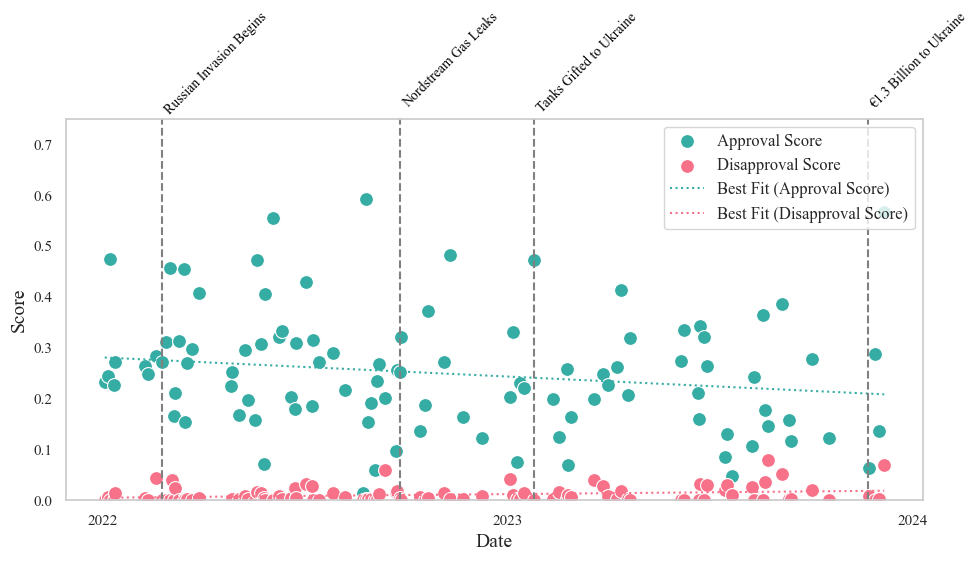

In [322]:
# Create the specific DataFrame
pre_app_dis_df = pd.DataFrame({
    'date': source_date_list,
    'approval_score': approval_scores,
    'disapproval_score': disapproval_scores
})

# Sort the DataFrame by the 'date' column
app_dis_df = pre_app_dis_df.sort_values(by='date')

# Print the sorted DataFrame
print(app_dis_df)

# Convert 'date' to numerical values
app_dis_df['date_numeric'] = app_dis_df['date'].astype(np.int64)

# Set seaborn style
sns.set(style="whitegrid")

# Set custom color palette
palette = sns.color_palette("husl", 2)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=app_dis_df, x='date', y='approval_score', label='Approval Score', color=palette[1], s=100)
sns.scatterplot(data=app_dis_df, x='date', y='disapproval_score', label='Disapproval Score', color=palette[0], s=100)

# Add a line of best fit for approval_score
coeff_approval = np.polyfit(app_dis_df['date_numeric'], app_dis_df['approval_score'], 1)
line_approval = np.polyval(coeff_approval, app_dis_df['date_numeric'])
plt.plot(app_dis_df['date'], line_approval, label='Best Fit (Approval Score)', linestyle='dotted', color=palette[1])

# Add a line of best fit for disapproval_score
coeff_disapproval = np.polyfit(app_dis_df['date_numeric'], app_dis_df['disapproval_score'], 1)
line_disapproval = np.polyval(coeff_disapproval, app_dis_df['date_numeric'])
plt.plot(app_dis_df['date'], line_disapproval, label='Best Fit (Disapproval Score)', linestyle='dotted', color=palette[0])

# Set labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Score', fontsize=14)


# Set x-axis tick locator and formatter for each new year
locator = YearLocator()
formatter = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Add a vertical line at a specific dates
specific_date = '2022-02-24'
specific_date_datetime = pd.to_datetime(specific_date) 
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Russian Invasion Begins'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1] * 1.55, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2022-09-26'
specific_date_datetime = pd.to_datetime(specific_date)  
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Nordstream Gas Leaks'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 1.55, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2023-01-25'  
specific_date_datetime = pd.to_datetime(specific_date)
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Tanks Gifted to Ukraine' 
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 1.55, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2023-11-21'  
specific_date_datetime = pd.to_datetime(specific_date)
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = '€1.3 Billion to Ukraine'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 1.55, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

# Remove grid lines within the plot
plt.grid(False)

# Display legend
plt.legend(fontsize=12)

# Set y-axis limit
plt.ylim(0, 0.75)

# Show the plot
plt.tight_layout()
plt.show()

In [315]:
from scipy.stats import pearsonr
import statsmodels.api as sm
import datetime as dt


In [250]:
# Assuming 'approval_scores' and 'disapproval_scores' are your variables
correlation_coefficient, p_value = pearsonr(app_dis_df['approval_score'], app_dis_df['disapproval_score'])

# Print the results
print(f"Pearson Correlation Coefficient (app & dis): {correlation_coefficient}")
print(f"P-value (app & dis): {p_value}")

Pearson Correlation Coefficient (app & dis): -0.012392432947928855
P-value (app & dis): 0.9011258088942131


In [329]:
app_dis_df['date_numeric'] = app_dis_df['date'].dt.strftime('%Y%m%d').astype(int)
# Drop rows with missing values
app_dis_df = app_dis_df.dropna(subset=['approval_score', 'date_numeric'])

# Fit OLS model
app_model = sm.OLS(app_dis_df['approval_score'], sm.add_constant(app_dis_df['date_numeric']))
app_results = app_model.fit()

# Print model summary
print(app_results.summary())

                            OLS Regression Results                            
Dep. Variable:         approval_score   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.620
Date:                Sun, 31 Dec 2023   Prob (F-statistic):              0.109
Time:                        14:05:43   Log-Likelihood:                 74.803
No. Observations:                 103   AIC:                            -145.6
Df Residuals:                     101   BIC:                            -140.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           77.7333     47.874      1.624   

In [330]:
app_dis_df['date_numeric'] = app_dis_df['date'].dt.strftime('%Y%m%d').astype(int)

# Drop rows with missing values
app_dis_df = app_dis_df.dropna(subset=['disapproval_score', 'date_numeric'])

# Fit OLS model
app_model = sm.OLS(app_dis_df['disapproval_score'], sm.add_constant(app_dis_df['date_numeric']))
app_results = app_model.fit()

# Print model summary
print(app_results.summary())

                            OLS Regression Results                            
Dep. Variable:      disapproval_score   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     5.686
Date:                Sun, 31 Dec 2023   Prob (F-statistic):             0.0190
Time:                        14:06:37   Log-Likelihood:                 285.76
No. Observations:                 103   AIC:                            -567.5
Df Residuals:                     101   BIC:                            -562.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.7120      6.175     -2.383   

         date  optimism_score  disappointment_score
52 2022-01-03        0.035050              0.047631
43 2022-01-06        0.021384              0.029319
56 2022-01-08        0.047445              0.002199
58 2022-01-11        0.010154              0.000658
84 2022-01-12        0.183191              0.011866
..        ...             ...                   ...
67 2023-10-17        0.028279              0.002027
75 2023-11-22        0.006728              0.044541
53 2023-11-28        0.109796              0.019459
20 2023-12-01        0.006534              0.006532
79 2023-12-06        0.024646              0.000382

[103 rows x 3 columns]


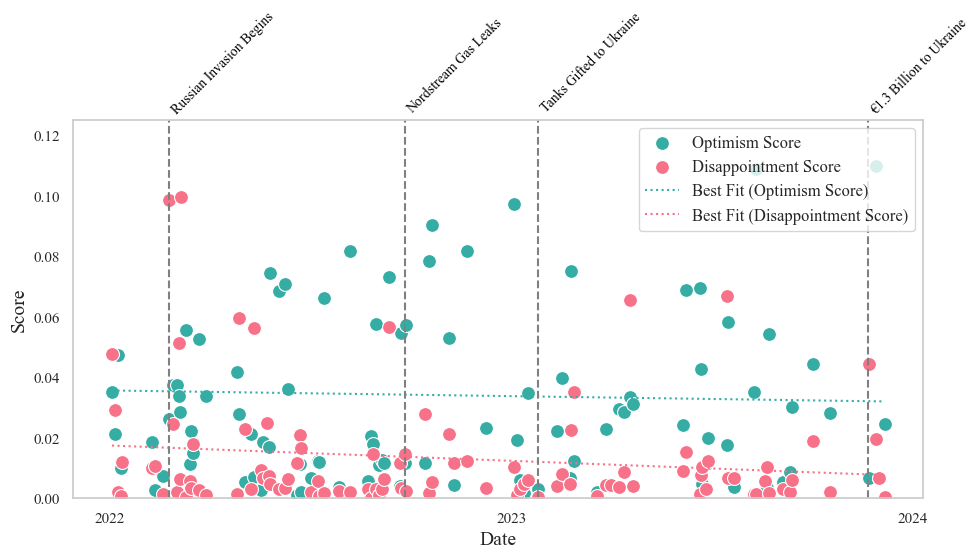

In [303]:
# Create the specific DataFrame
pre_opt_dis_df = pd.DataFrame({
    'date': source_date_list,
    'optimism_score': optimism_scores,
    'disappointment_score': disappointment_scores
})

# Sort the DataFrame by the 'date' column
opt_dis_df = pre_opt_dis_df.sort_values(by='date')

# Print the sorted DataFrame
print(opt_dis_df)

# Convert 'date' to numerical values
opt_dis_df['date_numeric'] = opt_dis_df['date'].astype(np.int64)

# Set seaborn style
sns.set(style="whitegrid")

# Set custom color palette
palette = sns.color_palette("husl", 2)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=opt_dis_df, x='date', y='optimism_score', label='Optimism Score', color=palette[1], s=100)
sns.scatterplot(data=opt_dis_df, x='date', y='disappointment_score', label='Disappointment Score', color=palette[0], s=100)

# Add a line of best fit for approval_score
coeff_approval = np.polyfit(opt_dis_df['date_numeric'], opt_dis_df['optimism_score'], 1)
line_approval = np.polyval(coeff_approval, opt_dis_df['date_numeric'])
plt.plot(opt_dis_df['date'], line_approval, label='Best Fit (Optimism Score)', linestyle='dotted', color=palette[1])

# Add a line of best fit for disapproval_score
coeff_disapproval = np.polyfit(opt_dis_df['date_numeric'], opt_dis_df['disappointment_score'], 1)
line_disapproval = np.polyval(coeff_disapproval, opt_dis_df['date_numeric'])
plt.plot(opt_dis_df['date'], line_disapproval, label='Best Fit (Disappointment Score)', linestyle='dotted', color=palette[0])

# Set labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set x-axis tick locator and formatter for each new year
locator = YearLocator()
formatter = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Add a vertical line at a specific dates
specific_date = '2022-02-24'
specific_date_datetime = pd.to_datetime(specific_date) 
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Russian Invasion Begins'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1] * 0.84, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2022-09-26'
specific_date_datetime = pd.to_datetime(specific_date)  
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Nordstream Gas Leaks'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 0.83, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2023-01-25'  
specific_date_datetime = pd.to_datetime(specific_date)
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Tanks Gifted to Ukraine' 
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 0.84, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2023-11-21'  
specific_date_datetime = pd.to_datetime(specific_date)
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = '€1.3 Billion to Ukraine'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 0.83, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)


# Remove grid lines within the plot
plt.grid(False)

# Set y-axis limit
plt.ylim(0, 0.125)

# Display legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [313]:
# Assuming 'approval_scores' and 'disapproval_scores' are your variables
correlation_coefficient, p_value = pearsonr(opt_dis_df['optimism_score'], opt_dis_df['disappointment_score'])

# Print the results
print(f"Pearson Correlation Coefficient (opt & dis): {correlation_coefficient}")
print(f"P-value (opt & dis): {p_value}")

Pearson Correlation Coefficient (opt & dis): 0.12624556329570855
P-value (opt & dis): 0.20383299884042835
101


In [331]:
opt_dis_df['date_numeric'] = opt_dis_df['date'].dt.strftime('%Y%m%d').astype(int)

# Drop rows with missing values
opt_dis_df = opt_dis_df.dropna(subset=['optimism_score', 'date_numeric'])

# Fit OLS model
opt_model = sm.OLS(opt_dis_df['optimism_score'], sm.add_constant(opt_dis_df['date_numeric']))
opt_results = opt_model.fit()

# Print model summary
print(opt_results.summary())

                            OLS Regression Results                            
Dep. Variable:         optimism_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.06106
Date:                Sun, 31 Dec 2023   Prob (F-statistic):              0.805
Time:                        14:07:37   Log-Likelihood:                 201.62
No. Observations:                 103   AIC:                            -399.2
Df Residuals:                     101   BIC:                            -394.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.4874     13.976      0.250   

In [332]:
opt_dis_df['date_numeric'] = opt_dis_df['date'].dt.strftime('%Y%m%d').astype(int)

# Drop rows with missing values
opt_dis_df = opt_dis_df.dropna(subset=['disappointment_score', 'date_numeric'])

# Fit OLS model
disa_model = sm.OLS(opt_dis_df['disappointment_score'], sm.add_constant(opt_dis_df['date_numeric']))
disa_results = disa_model.fit()

# Print model summary
print(disa_results.summary())

                             OLS Regression Results                             
Dep. Variable:     disappointment_score   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     1.230
Date:                  Sun, 31 Dec 2023   Prob (F-statistic):              0.270
Time:                          14:08:25   Log-Likelihood:                 261.64
No. Observations:                   103   AIC:                            -519.3
Df Residuals:                       101   BIC:                            -514.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.6684     

         date  anger_score  annoyance_score
52 2022-01-03     0.003090         0.002886
43 2022-01-06     0.018398         0.007011
56 2022-01-08     0.000242         0.003368
58 2022-01-11     0.000126         0.001351
84 2022-01-12     0.003600         0.007750
..        ...          ...              ...
67 2023-10-17     0.000096         0.000333
75 2023-11-22     0.002967         0.005428
53 2023-11-28     0.017585         0.005997
20 2023-12-01     0.000804         0.001900
79 2023-12-06     0.000070         0.000284

[103 rows x 3 columns]


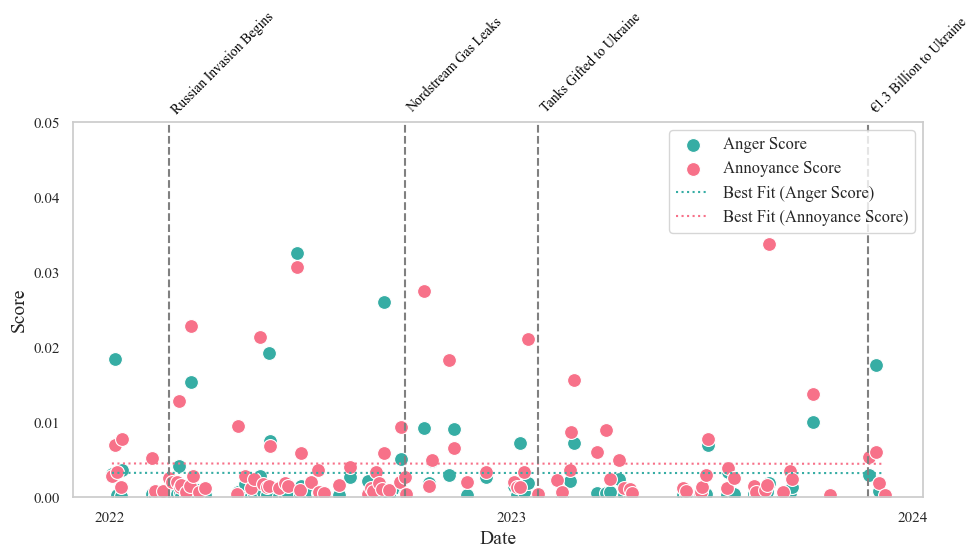

In [312]:
# Create the specific DataFrame
pre_ang_ann_df = pd.DataFrame({
    'date': source_date_list,
    'anger_score': anger_scores,
    'annoyance_score': annoyance_scores
})

# Sort the DataFrame by the 'date' column
ang_ann_df = pre_ang_ann_df.sort_values(by='date')

# Print the sorted DataFrame
print(ang_ann_df)

# Convert 'date' to numerical values
ang_ann_df['date_numeric'] = ang_ann_df['date'].astype(np.int64)

# Set seaborn style
sns.set(style="whitegrid")

# Set custom color palette
palette = sns.color_palette("husl", 2)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ang_ann_df, x='date', y='anger_score', label='Anger Score', color=palette[1], s=100)
sns.scatterplot(data=ang_ann_df, x='date', y='annoyance_score', label='Annoyance Score', color=palette[0], s=100)

# Add a line of best fit for approval_score
coeff_approval = np.polyfit(ang_ann_df['date_numeric'], ang_ann_df['anger_score'], 1)
line_approval = np.polyval(coeff_approval, ang_ann_df['date_numeric'])
plt.plot(ang_ann_df['date'], line_approval, label='Best Fit (Anger Score)', linestyle='dotted', color=palette[1])

# Add a line of best fit for disapproval_score
coeff_disapproval = np.polyfit(ang_ann_df['date_numeric'], ang_ann_df['annoyance_score'], 1)
line_disapproval = np.polyval(coeff_disapproval, ang_ann_df['date_numeric'])
plt.plot(ang_ann_df['date'], line_disapproval, label='Best Fit (Annoyance Score)', linestyle='dotted', color=palette[0])

# Set labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Score', fontsize=14)

# Set x-axis tick locator and formatter for each new year
locator = YearLocator()
formatter = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Add a vertical line at a specific dates
specific_date = '2022-02-24'
specific_date_datetime = pd.to_datetime(specific_date) 
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Russian Invasion Begins'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1] * 1, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2022-09-26'
specific_date_datetime = pd.to_datetime(specific_date)  
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Nordstream Gas Leaks'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 0.99, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2023-01-25'  
specific_date_datetime = pd.to_datetime(specific_date)
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = 'Tanks Gifted to Ukraine' 
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 1, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)

specific_date = '2023-11-21'  
specific_date_datetime = pd.to_datetime(specific_date)
plt.axvline(x=specific_date_datetime, color='gray', linestyle='--', label='')
label_text = '€1.3 Billion to Ukraine'  
plt.text(pd.to_datetime(specific_date_datetime), plt.ylim()[1]* 0.99, label_text, rotation=45, va='top', ha='left', color='black', fontsize=10)


# Remove grid lines within the plot
plt.grid(False)

# Set y-axis limit
plt.ylim(0, 0.05)

# Display legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'approval_scores' and 'disapproval_scores' are your variables
correlation_coefficient, p_value = pearsonr(ang_ann_df['anger_score'], ang_ann_df['annoyance_score'])

# Print the results
print(f"Pearson Correlation Coefficient (ang & ann): {correlation_coefficient}")
print(f"P-value (ang & ann): {p_value}")

In [333]:
ang_ann_df['date_numeric'] = ang_ann_df['date'].dt.strftime('%Y%m%d').astype(int)

# Drop rows with missing values
ang_ann_df = ang_ann_df.dropna(subset=['anger_score', 'date_numeric'])

# Fit OLS model
ang_model = sm.OLS(ang_ann_df['anger_score'], sm.add_constant(ang_ann_df['date_numeric']))
ang_results = ang_model.fit()

# Print model summary
print(ang_results.summary())

                            OLS Regression Results                            
Dep. Variable:            anger_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                  0.009784
Date:                Sun, 31 Dec 2023   Prob (F-statistic):              0.921
Time:                        14:09:10   Log-Likelihood:                 352.64
No. Observations:                 103   AIC:                            -701.3
Df Residuals:                     101   BIC:                            -696.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3158      3.226     -0.098   

In [334]:
ang_ann_df['date_numeric'] = ang_ann_df['date'].dt.strftime('%Y%m%d').astype(int)

# Drop rows with missing values
ang_ann_df = ang_ann_df.dropna(subset=['annoyance_score', 'date_numeric'])

# Fit OLS model
ann_model = sm.OLS(ang_ann_df['annoyance_score'], sm.add_constant(ang_ann_df['date_numeric']))
ann_results = ann_model.fit()

# Print model summary
print(ann_results.summary())

                            OLS Regression Results                            
Dep. Variable:        annoyance_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.03286
Date:                Sun, 31 Dec 2023   Prob (F-statistic):              0.857
Time:                        14:09:42   Log-Likelihood:                 373.85
No. Observations:                 103   AIC:                            -743.7
Df Residuals:                     101   BIC:                            -738.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4804      2.625      0.183   